# 🛍️ 电商用户行为分析与购买预测报告

## 📘 项目简介
本项目基于阿里天池电商用户行为数据集，通过数据清洗、行为分析、用户画像构建、以及机器学习建模等方式，深入挖掘用户转化路径与购买意图，辅助电商平台实现精准营销与用户分层运营。

---

## 🌟 项目亮点

### 🎯 内容亮点：
- 全面分析用户行为：点击 → 收藏 → 加购 → 购买的行为路径
- 构建用户画像，实现用户聚类（KMeans）
- 建立是否购买的预测模型（LightGBM），提升运营策略的智能化程度
- 可解释性分析（SHAP）帮助理解预测背后的关键特征

### 🧠 技术亮点：
- 大数据处理：按块读取并合并近 7600 万条行为数据
- 模型预测：使用 LightGBM 构建分类模型，结合标准化与分层采样
- 可视化：完整展示用户行为时段、转化率分布与模型解释结果

---

# Part 1: 特征工程

In [1]:
import pandas as pd
import zipfile
import os

zip_path = "Alibaba.zip"
csv_filename = "UserBehavior.csv"
chunk_size = 1_000_000
output_dir = "processed_chunks"
os.makedirs(output_dir, exist_ok=True)

# 列名和行为类型映射
column_names = ['user_id', 'product_id', 'product_category', 'behavior_type', 'timestamp']
behavior_map = {
    'pv': 'click',
    'buy': 'purchase',
    'cart': 'add_to_cart',
    'fav': 'favorite'
}

def process_chunk(chunk, i):
    
    # 行为类型映射
    chunk['behavior_type'] = chunk['behavior_type'].map(behavior_map)

    # 时间字段处理
    chunk['datetime'] = pd.to_datetime(chunk['timestamp'], unit='s')
    chunk['hour'] = chunk['datetime'].dt.hour
    chunk['weekday'] = chunk['datetime'].dt.weekday
    chunk['day'] = chunk['datetime'].dt.day
    chunk['date_str'] = chunk['datetime'].dt.strftime('%Y-%m-%d')

    # 用户行为统计
    user_behavior = chunk.groupby(['user_id', 'behavior_type']).size().unstack(fill_value=0).reset_index()
    user_behavior.rename(columns={
        'click': 'user_click_count',
        'favorite': 'user_fav_count',
        'add_to_cart': 'user_cart_count',
        'purchase': 'user_purchase_count'
    }, inplace=True)

    # 商品行为统计
    item_behavior = chunk.groupby(['product_id', 'behavior_type']).size().unstack(fill_value=0).reset_index()
    item_behavior.rename(columns={
        'click': 'item_click_count',
        'favorite': 'item_fav_count',
        'add_to_cart': 'item_cart_count',
        'purchase': 'item_purchase_count'
    }, inplace=True)
    item_behavior['item_conversion_rate'] = item_behavior['item_purchase_count'] / (item_behavior['item_click_count'] + 1e-5)

    # 用户-商品交互
    interaction = chunk.groupby(['user_id', 'product_id', 'behavior_type']).size().unstack(fill_value=0).reset_index()
    interaction.rename(columns={
        'click': 'ui_clicks',
        'favorite': 'ui_favs',
        'add_to_cart': 'ui_carts',
        'purchase': 'ui_purchases'
    }, inplace=True)

    # 合并核心特征
    merged = interaction.merge(user_behavior, on='user_id', how='left')
    merged = merged.merge(item_behavior, on='product_id', how='left')

    # 是否购买过该商品
    merged['label'] = (merged['ui_purchases'] > 0).astype(int)

    # 添加时间字段
    merged['hour'] = chunk.groupby(['user_id', 'product_id'])['hour'].first().values
    merged['weekday'] = chunk.groupby(['user_id', 'product_id'])['weekday'].first().values
    merged['date_str'] = chunk.groupby(['user_id', 'product_id'])['date_str'].first().values

    # 最终保留字段
    selected_cols = [
        'user_id', 'product_id',
        'ui_clicks', 'ui_carts', 'ui_favs', 'ui_purchases',
        'user_click_count', 'user_cart_count', 'user_purchase_count',
        'item_click_count', 'item_cart_count', 'item_purchase_count',
        'item_conversion_rate',
        'hour', 'weekday', 'date_str',
        'label'
    ]

    merged = merged[selected_cols]

    output_path = os.path.join(output_dir, f"chunk_{i}.parquet")
    merged.to_parquet(output_path, index=False)

with zipfile.ZipFile(zip_path) as z:
    with z.open(csv_filename) as f:
        reader = pd.read_csv(f, names=column_names, chunksize=chunk_size)
        for i, chunk in enumerate(reader):
            process_chunk(chunk, i)

In [2]:
import glob
import pandas as pd

all_chunks = glob.glob("processed_chunks/chunk_*.parquet")
df_list = []
for path in all_chunks:
    df_list.append(pd.read_parquet(path))

df_full = pd.concat(df_list, ignore_index=True)
df_full

,user_id,product_id,ui_clicks,ui_carts,ui_favs,ui_purchases,user_click_count,user_cart_count,user_purchase_count,item_click_count,item_cart_count,item_purchase_count,item_conversion_rate,hour,weekday,date_str,label
0,1,46259,2,0,0,0,55,0,0,2,0,0,0.000000,18,1,2017-11-28,0
1,1,79715,1,0,0,0,55,0,0,1,0,0,0.000000,17,3,2017-11-30,0
2,1,230380,1,0,0,0,55,0,0,22,2,0,0.000000,21,5,2017-11-25,0
3,1,266784,2,0,0,0,55,0,0,4,0,0,0.000000,15,1,2017-11-28,0
4,1,271696,1,0,0,0,55,0,0,20,0,0,0.000000,3,6,2017-12-03,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75970035,992842,4876800,1,0,0,0,105,2,1,54,6,1,0.018519,15,1,2017-11-28,0
75970036,992842,5001661,1,0,0,0,105,2,1,8,0,0,0.000000,15,5,2017-11-25,0
75970037,992842,5034795,1,0,0,0,105,2,1,1,0,0,0.000000,14,5,2017-11-25,0
75970038,992842,5072273,1,0,0,0,105,2,1,1,0,0,0.000000,6,1,2017-11-28,0


# Part 2: 用户研究

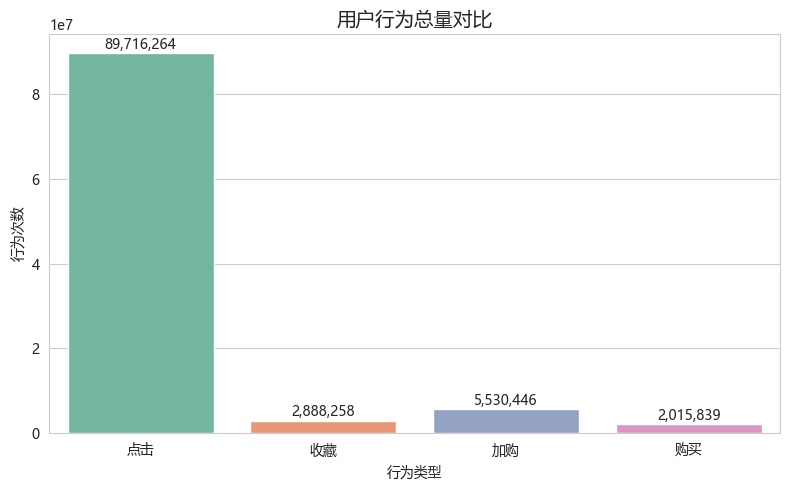

In [10]:
# 用户行为总量柱状图
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties

font_path = "C:/Windows/Fonts/msyh.ttc"
font_prop = FontProperties(fname=font_path)

matplotlib.rcParams['font.family'] = font_prop.get_name()
matplotlib.rcParams['axes.unicode_minus'] = False

behavior_totals = {
    '点击': df_full['ui_clicks'].sum(),
    '收藏': df_full['ui_favs'].sum(),
    '加购': df_full['ui_carts'].sum(),
    '购买': df_full['ui_purchases'].sum()
}
plt.figure(figsize=(8, 5))
sns.barplot(x=list(behavior_totals.keys()), y=list(behavior_totals.values()), palette="Set2")
plt.title("用户行为总量对比", fontsize=14)
plt.ylabel("行为次数")
plt.xlabel("行为类型")
for index, value in enumerate(behavior_totals.values()):
    plt.text(index, value + 1e6, f'{int(value):,}', ha='center', fontsize=10)
plt.tight_layout()
plt.show()

### 📊 用户行为总量对比

> 💡 **Insights：**
> - 点击行为遥遥领先，接近 9000 万次，占比超 80%
> - 购买行为仅占比约 2.2%，显示转化瓶颈明显
> - 收藏与加购作为中间行为，分别约占 3% 和 6%
> - 平台面临的是大量流量但转化率偏低的问题，后续应重点分析转化路径与行为驱动因素

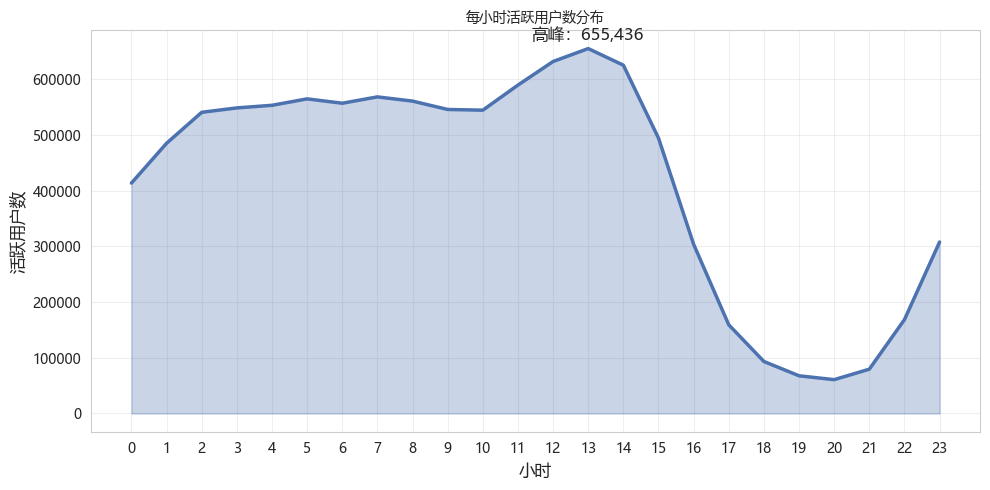

In [12]:
# 每小时活跃用户数
font_prop = FontProperties(fname="C:/Windows/Fonts/msyh.ttc")
active_users = df_full.groupby('hour')['user_id'].nunique()
plt.figure(figsize=(10, 5))
sns.set_style("whitegrid")
sns.lineplot(x=active_users.index, y=active_users.values, linewidth=2.5, color="#4C72B0")
plt.fill_between(active_users.index, active_users.values, alpha=0.3, color="#4C72B0")

peak_hour = active_users.idxmax()
peak_value = active_users.max()
plt.text(peak_hour, peak_value + 15000, f"高峰：{peak_value:,}", ha='center', fontsize=12, fontproperties=font_prop)

plt.title("每小时活跃用户数分布", fontsize=16, fontproperties=font_prop)
plt.xlabel("小时", fontsize=12, fontproperties=font_prop)
plt.ylabel("活跃用户数", fontsize=12, fontproperties=font_prop)
plt.xticks(range(0, 24), fontproperties=font_prop)
plt.yticks(fontproperties=font_prop)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

### 📊 用户活跃时段分析

> 💡 **Insights：**
> - 活跃高峰集中在中午 12~14 点，最大峰值达 65 万人
> - 晚间 20 点后活跃度明显下降
> - 中午为用户浏览黄金时段，适合投放优惠 / 精选内容；凌晨活跃度虽低但转化率高（见后续转化率图），值得测试夜间促销策略

D:\Anaconda\Lib\site-packages\seaborn\utils.py:80: UserWarning: Glyph 21608 (\N{CJK UNIFIED IDEOGRAPH-5468}) missing from current font.
  fig.canvas.draw()
D:\Anaconda\Lib\site-packages\seaborn\utils.py:80: UserWarning: Glyph 19968 (\N{CJK UNIFIED IDEOGRAPH-4E00}) missing from current font.
  fig.canvas.draw()
D:\Anaconda\Lib\site-packages\seaborn\utils.py:80: UserWarning: Glyph 20108 (\N{CJK UNIFIED IDEOGRAPH-4E8C}) missing from current font.
  fig.canvas.draw()
D:\Anaconda\Lib\site-packages\seaborn\utils.py:80: UserWarning: Glyph 19977 (\N{CJK UNIFIED IDEOGRAPH-4E09}) missing from current font.
  fig.canvas.draw()
D:\Anaconda\Lib\site-packages\seaborn\utils.py:80: UserWarning: Glyph 22235 (\N{CJK UNIFIED IDEOGRAPH-56DB}) missing from current font.
  fig.canvas.draw()
D:\Anaconda\Lib\site-packages\seaborn\utils.py:80: UserWarning: Glyph 20116 (\N{CJK UNIFIED IDEOGRAPH-4E94}) missing from current font.
  fig.canvas.draw()
D:\Anaconda\Lib\site-packages\seaborn\utils.py:80: UserWarning: 

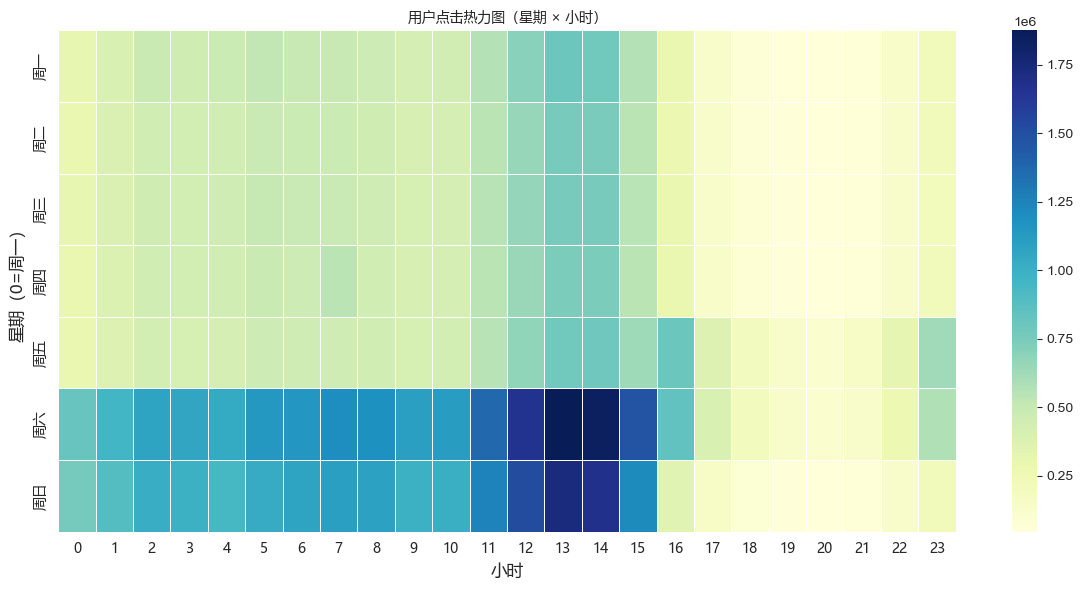

In [16]:
# 点击热力图（星期×小时）
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
font_prop = FontProperties(fname="C:/Windows/Fonts/msyh.ttc")

click_heatmap = df_full.pivot_table(
    index='weekday', columns='hour', values='ui_clicks', aggfunc='sum', fill_value=0
)

plt.figure(figsize=(12, 6))
click_heatmap.index = ['周一', '周二', '周三', '周四', '周五', '周六', '周日']
sns.heatmap(click_heatmap, cmap="YlGnBu", linewidths=0.5, annot=False)

plt.title("用户点击热力图（星期 × 小时）", fontsize=16, fontproperties=font_prop)
plt.xlabel("小时", fontsize=12, fontproperties=font_prop)
plt.ylabel("星期（0=周一）", fontsize=12, fontproperties=font_prop)
plt.xticks(fontproperties=font_prop)
plt.yticks(fontproperties=font_prop)

plt.tight_layout()
plt.show()

### 📊 点击热力图（按星期 × 小时）

> 💡 **Insights：**
> - 周末（尤其周六）点击量激增，特别是中午时段
> - 工作日集中点击出现在午间和下午
> - 应加大周末商品曝光策略，尤其午间推广投放，或结合节日营销精准运营

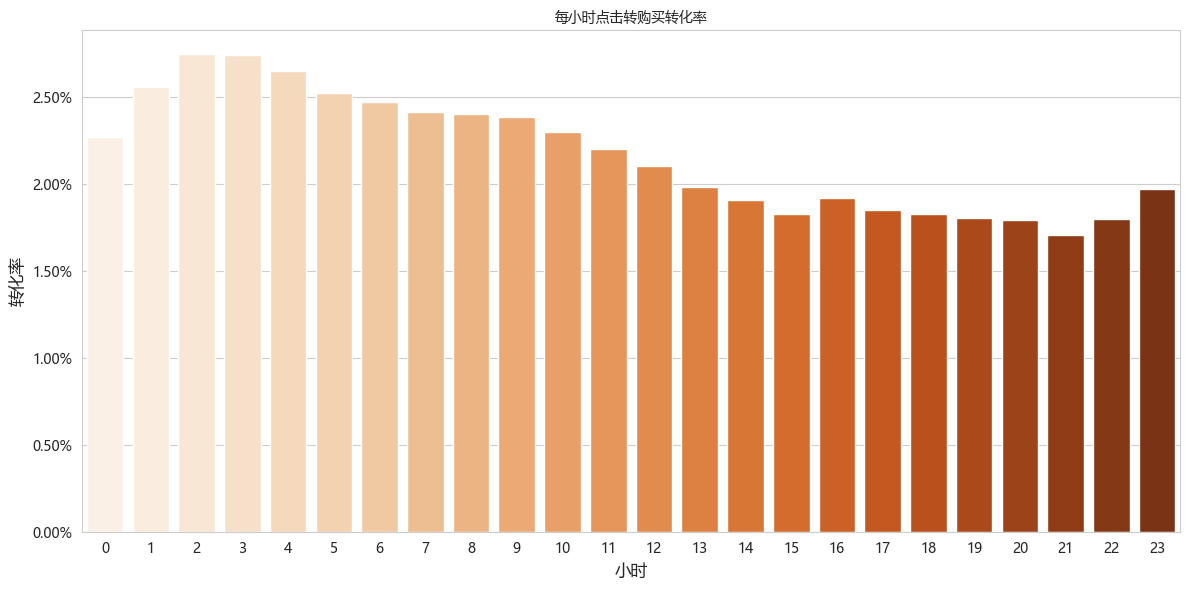

In [18]:
# 每小时点击转购买转化率
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
from matplotlib.font_manager import FontProperties
import seaborn as sns
font_prop = FontProperties(fname="C:/Windows/Fonts/msyh.ttc")

hourly = df_full.groupby('hour')[['ui_clicks', 'ui_purchases']].sum()
hourly['转化率'] = hourly['ui_purchases'] / (hourly['ui_clicks'] + 1e-5)

plt.figure(figsize=(12, 6))
sns.barplot(x=hourly.index, y=hourly['转化率'], palette='Oranges')
plt.gca().yaxis.set_major_formatter(PercentFormatter(1.0))
plt.title("每小时点击转购买转化率", fontsize=16, fontproperties=font_prop)
plt.xlabel("小时", fontsize=12, fontproperties=font_prop)
plt.ylabel("转化率", fontsize=12, fontproperties=font_prop)
plt.xticks(fontproperties=font_prop)
plt.yticks(fontproperties=font_prop)
plt.tight_layout()
plt.show()

### 📊 每小时点击转化率分析

> 💡 **Insights：**
> - 凌晨 3~5 点为转化率最高时段（超 2.7%）
> - 白天流量高但转化效率反而下降
> - 说明夜间浏览的用户购买意图更强，适合推送限时抢购、深夜秒杀活动

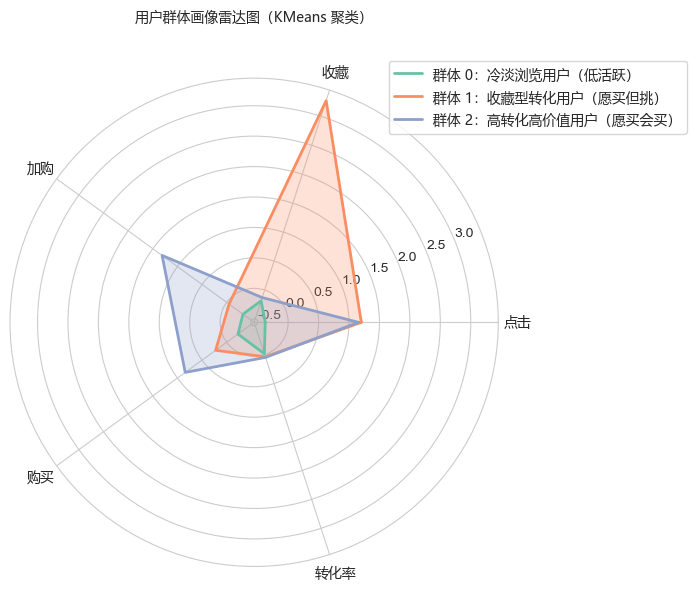

In [21]:
# 用户画像雷达图（KMeans）
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
font_prop = FontProperties(fname="C:/Windows/Fonts/msyh.ttc")

# 聚类
user_features = df_full.groupby('user_id')[['ui_clicks', 'ui_favs', 'ui_carts', 'ui_purchases']].sum()
user_features['conversion_rate'] = user_features['ui_purchases'] / (user_features['ui_clicks'] + 1e-5)
feature_cols = ['ui_clicks', 'ui_favs', 'ui_carts', 'ui_purchases', 'conversion_rate']
scaler = StandardScaler()
X_scaled = scaler.fit_transform(user_features[feature_cols])
kmeans = KMeans(n_clusters=3, random_state=42, n_init='auto')
user_features['cluster'] = kmeans.fit_predict(X_scaled)
centroids = kmeans.cluster_centers_

labels = ['点击', '收藏', '加购', '购买', '转化率']
angles = np.linspace(0, 2 * np.pi, len(labels), endpoint=False).tolist()
angles += angles[:1]
colors = ['#66C2A5', '#FC8D62', '#8DA0CB']

group_labels = [
    "群体 0：冷淡浏览用户（低活跃）",
    "群体 1：收藏型转化用户（愿买但挑）",
    "群体 2：高转化高价值用户（愿买会买）"
]

plt.figure(figsize=(7, 6))
for i, color in enumerate(colors):
    values = centroids[i]
    values = np.concatenate((values, [values[0]])) 
    plt.polar(angles, values, label=group_labels[i], color=color, linewidth=2)
    plt.fill(angles, values, color=color, alpha=0.25)

plt.xticks(angles[:-1], labels, fontsize=11, fontproperties=font_prop)
plt.title("用户群体画像雷达图（KMeans 聚类）", fontsize=16, fontproperties=font_prop, y=1.1)
plt.legend(loc='upper right', bbox_to_anchor=(1.4, 1.05), fontsize=11, prop=font_prop)
plt.tight_layout()
plt.show()

### 📊 用户画像聚类分析（KMeans）

> 💡 **Insights：**
> - 用户群体主要分为三类：冷淡用户，仅浏览，无后续动作；收藏偏好型，愿买但犹豫；高转化用户，活跃且购买强
> - 可根据群体特征进行差异化运营，比如对收藏型用户推送优惠券，对高转化用户提前预热新品

# Part 3: 漏斗分析

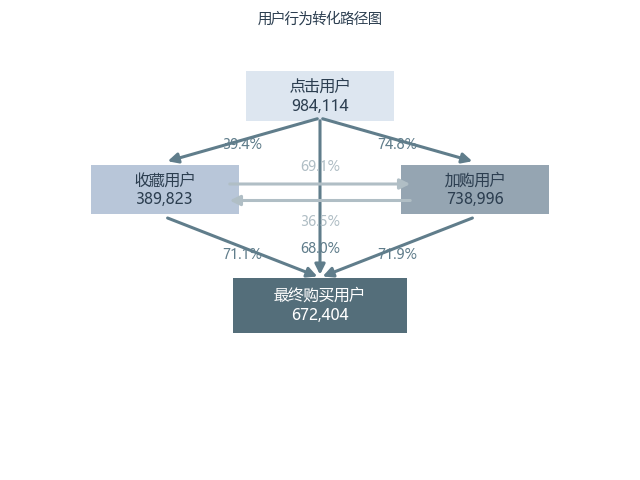

In [56]:
import matplotlib.pyplot as plt
from matplotlib.patches import FancyArrowPatch, Rectangle
from matplotlib.font_manager import FontProperties
font_prop = FontProperties(fname="C:/Windows/Fonts/msyh.ttc")

click_users = set(df_full[df_full['ui_clicks'] > 0]['user_id'])
fav_users = set(df_full[df_full['ui_favs'] > 0]['user_id'])
cart_users = set(df_full[df_full['ui_carts'] > 0]['user_id'])
buy_users = set(df_full[df_full['ui_purchases'] > 0]['user_id'])

click_to_buy = len(click_users & buy_users)
fav_to_buy = len(fav_users & buy_users)
cart_to_buy = len(cart_users & buy_users)

rate_click_buy = click_to_buy / len(click_users) * 100
rate_fav_buy = fav_to_buy / len(fav_users) * 100
rate_cart_buy = cart_to_buy / len(cart_users) * 100

rate_click_to_fav = len(click_users & fav_users) / len(click_users) * 100
rate_click_to_cart = len(click_users & cart_users) / len(click_users) * 100
rate_fav_to_cart = len(fav_users & cart_users) / len(fav_users) * 100
rate_cart_to_fav = len(cart_users & fav_users) / len(cart_users) * 100

colors = {
    '点击': '#DDE6F0',
    '收藏': '#B8C6D9',
    '加购': '#95A5B2',
    '购买': '#546E7A',
    '背景': '#FFFFFF',
    '文字': '#2C3E50',
    '箭头': '#607D8B',
    '箭头浅色': '#B0BEC5'
}

fig, ax = plt.subplots(figsize=(8, 5.5))  
ax.set_xlim(0, 10)
ax.set_ylim(0, 8)
ax.set_facecolor(colors['背景'])
ax.axis('off')

def draw_box(x, y, w, h, title, val, color, text_color='#2C3E50'):
    rect = Rectangle((x - w/2, y - h/2), w, h, facecolor=color, edgecolor='none')
    ax.add_patch(rect)
    ax.text(x, y, f"{title}\n{val:,}", ha='center', va='center',
            fontsize=11, fontproperties=font_prop, color=text_color)

def draw_arrow(p1, p2, text=None, color=colors['箭头'], text_position='above', text_offset_y=None):
    ax.add_patch(FancyArrowPatch(p1, p2, arrowstyle='-|>', color=color, lw=2.2, mutation_scale=15))
    if text is not None:
        mx, my = (p1[0] + p2[0]) / 2, (p1[1] + p2[1]) / 2
        if text_offset_y is not None:
            dy = text_offset_y
        else:
            dy = 0.25 if text_position == 'above' else -0.45
        ax.text(mx, my + dy, f"{text:.1f}%", ha='center', fontsize=10, fontproperties=font_prop, color=color)

draw_box(5, 6.8, 2.4, 0.9, "点击用户", len(click_users), colors['点击'])
draw_box(2.5, 5.1, 2.4, 0.9, "收藏用户", len(fav_users), colors['收藏'])
draw_box(7.5, 5.1, 2.4, 0.9, "加购用户", len(cart_users), colors['加购'])
draw_box(5, 3.0, 2.8, 1.0, "最终购买用户", len(buy_users), colors['购买'], 'white')

# 点击 → 收藏 / 加购
draw_arrow((5, 6.4), (2.5, 5.6), rate_click_to_fav, text_offset_y=-0.15)
draw_arrow((5, 6.4), (7.5, 5.6), rate_click_to_cart, text_offset_y=-0.15)
# 点击 / 收藏 / 加购 → 购买
draw_arrow((2.5, 4.6), (5, 3.5), rate_fav_buy, text_offset_y=-0.2)
draw_arrow((7.5, 4.6), (5, 3.5), rate_cart_buy, text_offset_y=-0.2)
draw_arrow((5, 6.4), (5, 3.5), rate_click_buy, text_offset_y=-1.0)
# 收藏 ↔ 加购
draw_arrow((3.5, 5.2), (6.5, 5.2), rate_fav_to_cart, color=colors['箭头浅色'], text_position='above')
draw_arrow((6.5, 4.9), (3.5, 4.9), rate_cart_to_fav, color=colors['箭头浅色'], text_position='below')

plt.title("用户行为转化路径图", fontsize=15, fontproperties=font_prop, color=colors['文字'])
plt.subplots_adjust(top=0.88, bottom=0.08)
plt.show()

### 📊 用户转化路径分析图（漏斗图）

> 💡 **Insights：**
> - 点击到加购的转化率高达 75%
> - 收藏与加购之间存在明显互转关系
> - 收藏到购买相对偏低（71%）
> - 应优化收藏→加购→购买路径，比如：收藏夹商品动态提醒，提高最终购买率

# Part 4: 购买预测

In [63]:
import pandas as pd
import lightgbm as lgb
import shap
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
)

feature_cols = [
    'ui_clicks', 'ui_carts', 'ui_favs',
    'user_click_count', 'user_cart_count', 'user_purchase_count',
    'item_click_count', 'item_cart_count', 'item_purchase_count',
    'item_conversion_rate', 'hour', 'weekday'
]

# 数据采样
df_sampled = df_full.sample(n=50000, random_state=42)

X = df_sampled[feature_cols]
y = df_sampled['label']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

# LightGBM 
lgbm = lgb.LGBMClassifier(n_estimators=100, random_state=42)
lgbm.fit(X_train, y_train)

[LightGBM] [Info] Number of positive: 996, number of negative: 39004
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002916 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 815
[LightGBM] [Info] Number of data points in the train set: 40000, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.024900 -> initscore=-3.667672
[LightGBM] [Info] Start training from score -3.667672


LGBMClassifier(random_state=42)

In [64]:
# 模型评估
y_probs = lgbm.predict_proba(X_test)[:, 1]
y_pred = (y_probs > 0.5).astype(int)

print("准确率：", accuracy_score(y_test, y_pred))
print("精确率：", precision_score(y_test, y_pred))
print("召回率：", recall_score(y_test, y_pred))
print("F1分数：", f1_score(y_test, y_pred))
print("AUC：", roc_auc_score(y_test, y_probs))

准确率： 0.9896
精确率： 0.8222222222222222
召回率： 0.7429718875502008
F1分数： 0.7805907172995781
AUC： 0.9959394546702861


### 📈 模型评估指标分析

| 指标     | 值          |
|------------|-----------------|
| 准确率    | 0.9896       |
| 精确率    | 0.8222       |
| 召回率    | 0.7430       |
| F1分数    | 0.7806       |
| AUC值     | 0.9959       |

- 模型整体判断是否购买的准确率非常高，但考虑到样本存在类别不平衡（大多数为未购买），准确率不能完全反映模型好坏。
- 在被模型判断为“会购买”的用户中，有 82% 是实际会购买的，说明模型**推荐质量较高**，适合用于资源敏感型推荐（如优惠券发放）。
- 能够识别出74%的实际购买用户，说明模型对“潜在购买者”的覆盖面尚可，但还有进一步优化空间。
- 综合精确率与召回率，说明模型在**精确识别与全面覆盖之间达到了良好平衡**。
- 接近 1 的 AUC 表明模型在区分正负样本方面几乎完美，具备非常强的分类能力，是企业落地部署的有力候选。
模型不仅准确率高，**在识别购买用户时也兼顾了精准度和召回能力**，可作为推荐系统的核心组件。

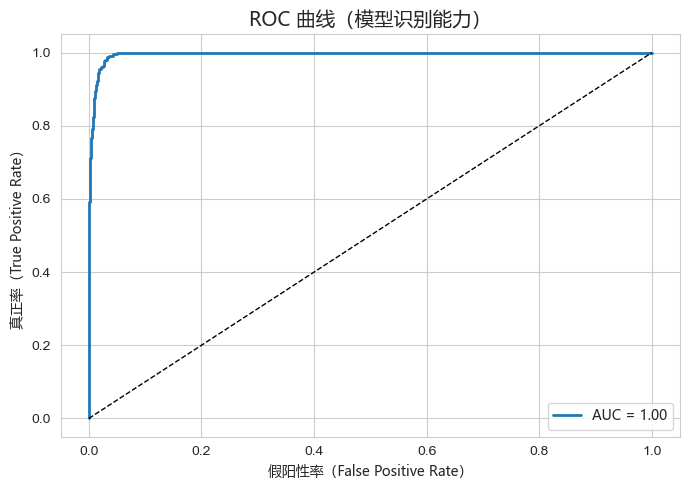

In [67]:
# ROC 曲线
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
from sklearn.metrics import roc_curve, roc_auc_score
font_prop = FontProperties(fname="C:/Windows/Fonts/msyh.ttc")

fpr, tpr, _ = roc_curve(y_test, y_probs)
auc_score = roc_auc_score(y_test, y_probs)

plt.figure(figsize=(7, 5))
plt.plot(fpr, tpr, label=f"AUC = {auc_score:.2f}", lw=2)
plt.plot([0, 1], [0, 1], 'k--', lw=1)

plt.xlabel("假阳性率（False Positive Rate）", fontproperties=font_prop)
plt.ylabel("真正率（True Positive Rate）", fontproperties=font_prop)
plt.title("ROC 曲线（模型识别能力）", fontproperties=font_prop, fontsize=14)
plt.legend(prop=font_prop)
plt.grid(True)
plt.tight_layout()
plt.show()

### 📊 LightGBM 预测表现评估

> 💡 **Insights：**
> - AUC ≈ 1.00，模型识别能力极强
> - 表现略显“过拟合”，可考虑时间滑窗 / 数据去重
> - 模型可用于预测高意图用户，辅助精准营销、推荐与复购策略

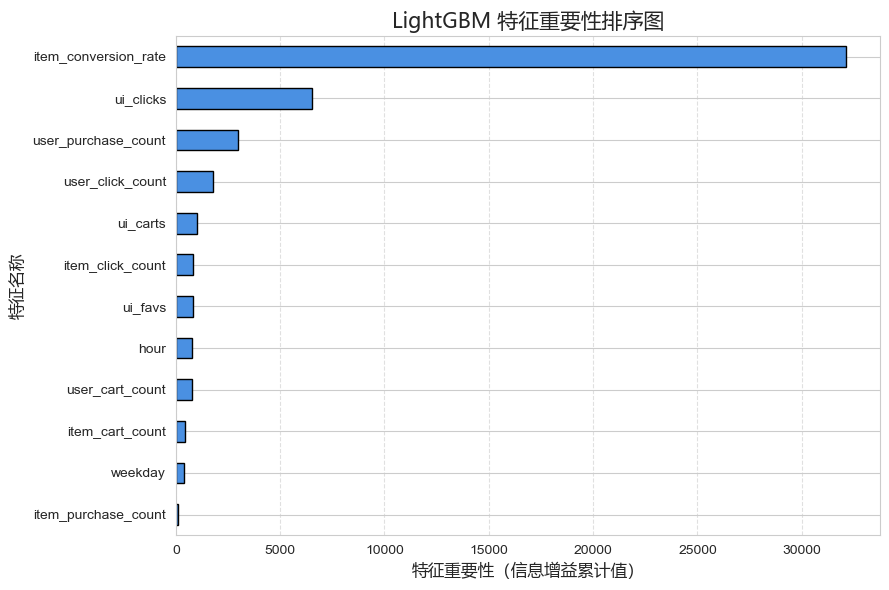

In [72]:
# 特征重要性
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
font_prop = FontProperties(fname="C:/Windows/Fonts/msyh.ttc")

feat_imp = pd.Series(
    lgbm.booster_.feature_importance(importance_type='gain'),
    index=feature_cols
).sort_values()

plt.figure(figsize=(9, 6))
feat_imp.plot(
    kind='barh',
    color='#4A90E2',
    edgecolor='black'
)
plt.title("LightGBM 特征重要性排序图", fontproperties=font_prop, fontsize=15)
plt.xlabel("特征重要性（信息增益累计值）", fontproperties=font_prop, fontsize=12)
plt.ylabel("特征名称", fontproperties=font_prop, fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

### 📊 特征重要性分析

> 💡 **Insights：**
> - `item_conversion_rate` 是最重要的影响因子
> - 用户历史购买行为 `user_purchase_count` 排名靠前
> - 说明商品本身转化表现 + 用户历史活跃度 是预测购买的核心指标

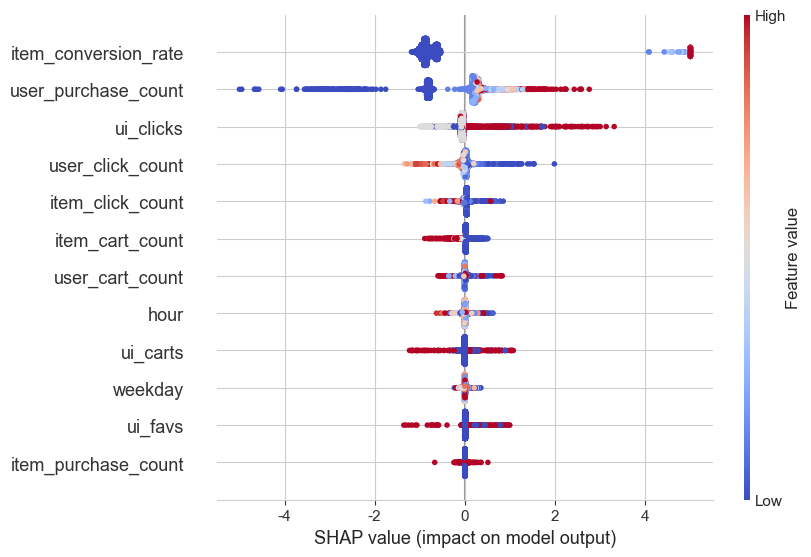

In [69]:
# Beewarm图
import shap
import numpy as np
from matplotlib.font_manager import FontProperties
font_prop = FontProperties(fname="C:/Windows/Fonts/msyh.ttc")

explainer = shap.Explainer(lgbm)
shap_values = explainer(X_test)
shap_values.feature_names = feature_cols
shap_values.values = np.clip(shap_values.values, -5, 5)

shap.plots.beeswarm(
    shap_values,
    max_display=12,
    color=plt.cm.coolwarm,  
    show=True  #
)

### 📊 可解释性分析

> 💡 **Insights：**
> - SHAP 分析显示 `item_conversion_rate` 和 `user_purchase_count` 对预测值贡献最大
> -  `hour`, `weekday` 等时序因素虽弱但方向明确
> - 结合 SHAP，可发现哪些特征实际“推高”了用户的购买概率，有助于策略制定与落地部署

# Part 5: 业务建议

基于本次分析与建模成果，针对电商平台在用户运营与商品推荐方面，给出以下可落地的策略建议：

### 针对高购买意图用户
- **提前曝光、个性化推荐：** 模型已可有效识别此类用户，应重点推送热卖商品、新品首发等内容
- **优惠券精准投放：** 节省预算的同时提高转化率

###  针对“收藏后未购买”用户
- **发起收藏提醒 / 降价通知**
- **提供“加购激励”：** 如满减门槛更低、赠品优惠等

### 商品维度优化
- `item_conversion_rate` 是影响购买的首要因素，平台应：
  - 提升低转化商品的描述、图片与评论质量
  - 对高转化商品提高排序权重或重点推广

### 精准营销时段建议
- 活跃高峰：中午 12-14 点、周末（尤其周六）为核心营销时段
- 高转化时段：凌晨 2~5 点用户转化意愿更强，可结合“夜间专属优惠”活动

---

通过行为分析 + 聚类分群 + 预测建模 + 可解释性输出的全流程，本项目已具备一定的产品化能力，后续可用于：
- 广告投放优化
- 精细化人群运营
- 推荐系统用户标签强化
- 营销活动转化提升